## This notebook explores a basic jerk analysis for the path model for jerk signatures. 
### It shows how to read in the datafiles from https://morpho.ipgp.fr/4DEarth/ and produce basic figures.

In [1]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
sys.path.append( os.path.abspath('..') ) #This line needs to point to whereever the jerks module has been compiled.
from jerks import jerks

In [2]:
# Download the spherical harmonic time-series output from the path model
import os.path
if not os.path.exists('Gauss_Bsurf.mat'): 
    !wget http://morpho.ipgp.fr/4DEarth/Gauss_Bsurf.mat

In [3]:
# import the (Matlab formatted) dataset
import h5py
filepath = 'Gauss_Bsurf.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

In [4]:
coeffs = arrays['gnm'][:,:].T
time = arrays['timers'].flatten()
print( 'Shape of gmn array: ', arrays['gnm'].shape )
print ('Times (in years) of output', time )

Shape of gmn array:  (960, 50001)
Times (in years) of output [ 4200.   4200.2  4200.4 ... 14199.6 14199.8 14200. ]


In [5]:
# jerk times as defined in catalogue
jerk_times = [4600,5750,2920, 1915, 6490,7300,7620,7840,8880,9673,10590,12620,13411,13546]

#### Plot a picture of Br at the CMB at the time of jerk 9 (Python index 8, t=8880) to check that everything works

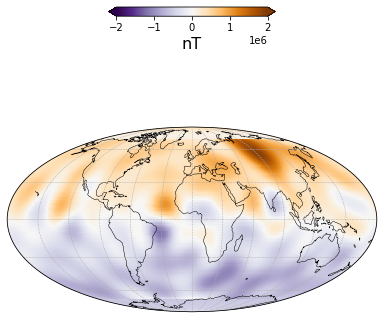

In [6]:
import chaosmagpy as cp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

index = np.argmin(abs(time-jerk_times[8]))

coeffs_single_epoch = arrays['gnm'][:,index]

radius = 3485.

theta = np.linspace(1., 179., 181)
phi = np.linspace(-180., 180, 361)
Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs_single_epoch, radius, theta, phi, grid=True,nmax=13)

limit = 2e6  # nT colorbar limit

# create figure
fig = plt.figure(figsize=(16, 10))

# make array of axes
axes = []
gs = fig.add_gridspec(3,3)
axes.append(plt.subplot(gs[1, :], projection=ccrs.Mollweide()))

for ax in axes:
    pc = ax.pcolormesh(phi, 90. - theta, Br, cmap='PuOr_r', vmin=-limit,
                       vmax=limit, transform=ccrs.PlateCarree())
    ax.gridlines(linewidth=0.5, linestyle='dashed',
                 ylocs=np.linspace(-90, 90, num=7),  # parallels
                 xlocs=np.linspace(-180, 180, num=13))  # meridians
    ax.coastlines(linewidth=0.5)

# inset axes into global map and move upwards
cax = inset_axes(axes[-1], width="45%", height="5%", loc='upper center',
                 borderpad=-12)

# use last artist for the colorbar
clb = plt.colorbar(pc, cax=cax, extend='both', orientation='horizontal')
clb.set_label('nT', fontsize=16)

plt.subplots_adjust(top=0.785, bottom=0.015, left=0.008,
                    right=0.992, hspace=0.0, wspace=0.0)

# Analysis of jerk 9

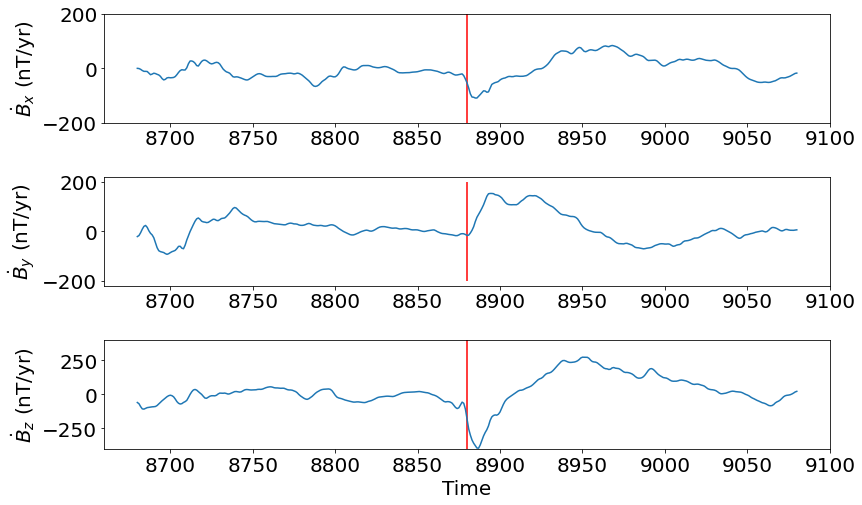

In [7]:
# plot SV series at theta = 90, phi = 45 which is close to the centre point of the jerk event in the SA.
radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


a = 200
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13,8) )
ax1.vlines(jerk_times[jerk_number],-a,a,'r')
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('$\dot{B}_x$ (nT/yr)',fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)

a=200
ax2.vlines(jerk_times[jerk_number],-a,a,'r')
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
#ax2.set_ylim(-200,200)
ax2.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

#ax2.set_title(r'$d{B_Y}/dt$')
a=400
ax3.vlines(jerk_times[jerk_number],-a,a,'r')
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-400,400)
ax3.set_xlabel('Time',fontsize=20)
ax3.set_ylabel('$\dot{B}_z$ (nT/yr)',fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)

#ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_SV_timeseries.pdf')

#### Run jerk finder on using a 10% relative error on 400 year interval (400 data).

In [42]:
run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 2000000+burn_in    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
jerk_data_save =np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2,3),dtype=float )
size_jerk_data_save  = np.zeros(3, dtype=int)

CP_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=float )

jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2),dtype=float )
size_jerk_data = 0

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    
    sigmas = np.array([ (SV.max() - SV.min())*0.08,\
                       (TIMES_MAX - TIMES_MIN)*0.02,(SV.max() - SV.min())*0.08],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save[:,:,i] = jerk_data
    size_jerk_data_save[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

0 [36.42160034 30.61986542  4.06815481  4.07975721]
1 [37.16030121 28.46379852  5.06550121  5.08017445]
2 [32.08280182 40.45378494  9.41998196  9.44615173]


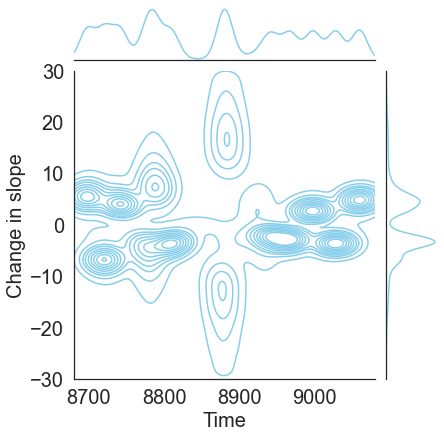

In [43]:
# Make kde image using seaborn:
import seaborn as sns
import pandas as pd
sns.set(style="white", color_codes=True)
joint_data = pd.DataFrame(data=jerk_data_save[0:size_jerk_data_save[0],:,0],columns=["time","change"])
joint_data = joint_data[ abs(joint_data["change"])<30 ]

# Draws a kernel density estimate (kde) of the pdf, using 10 equally spaced contour levels in probability density.

image = sns.jointplot(x=joint_data.time, y=joint_data.change, kind = 'kde', levels=10, ylim=[-30,30],xlim = [TIMES_MIN, TIMES_MAX], color="skyblue")

plt.xlabel('Time', fontsize=20);
plt.ylabel('Change in slope', fontsize=20);
plt.tick_params(axis='both', which='major', labelsize=20)


Text(0, 0.5, 'Change in slope')

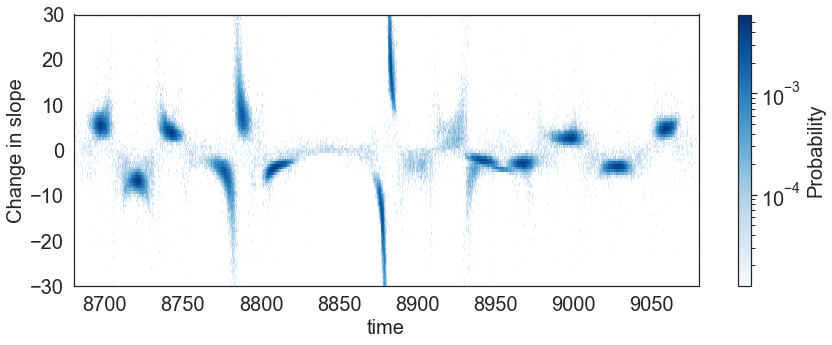

In [46]:
data_timing = jerk_data_save[0:size_jerk_data_save[0],0,0]
data_amplitude = jerk_data_save[0:size_jerk_data_save[0],1,0]

import matplotlib.colors as colors
fig, ax = plt.subplots( figsize=(14,5))
counts, xedges, yedges, im = ax.hist2d(data_timing, data_amplitude, bins=(int(TIMES_MAX-TIMES_MIN)*2,100), range=[[TIMES_MIN,TIMES_MAX], [-30,30]],density=True, \
                                       cmap='Blues',norm=colors.LogNorm() )
cb = fig.colorbar(im, ax=ax)
cb.set_label("Probability", labelpad=6, size=20)
cb.ax.tick_params(labelsize=20)


ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('Change in slope', fontsize=20)


In [47]:
# find jerks:

# 1. Find peaks in marginal histogram of changepoints
# 2. For those peaks satisfying certain criteria like min distance between jerks and jerk prominence, 
# and for which the associated modal amplitude (from the 2d histogram) exceeds a certain threshold, label the peak a a jerk
# 3. Find the jerk width by seeing how far either side of the peak the 1d histogram drops to tau of the value at the peak.

def find_jerks(data_timing, data_amplitude, number_time_bins, number_amplitude_bins, time_range, amplitude_range):

    jerk_min_amplitude = 1
    min_distance = 6 #jerks peaks have a width of at least 1 year, and are at least 3 years from another jerk.
    peak_prominence = 1
    tau = 0.2

    jerks_overall_info = []

    

    counts, xedges, yedges = np.histogram2d(data_timing, data_amplitude, bins=(number_time_bins,number_amplitude_bins), range=[time_range, amplitude_range])
    marginal_counts, marginal_xedges = np.histogram( data_timing, bins=number_time_bins, range=time_range)
    from scipy import signal

    peaks = signal.find_peaks(marginal_counts,distance=min_distance, prominence = peak_prominence * marginal_counts.mean() )  

    for peak_index in peaks[0]:
        jerk_info = np.zeros(4)
        index = counts[peak_index,:].argmax()  #find index corresponding to max probability
        jerk_amplitude = 0.5 * ( yedges[index] + yedges[index+1] )  #use the centre point of the bin
        if abs(jerk_amplitude) > jerk_min_amplitude:
            jerk_info[0] = 0.5 * ( marginal_xedges[peak_index] + marginal_xedges[peak_index+1] )  #use the centre point of the bin
            jerk_info[1] = jerk_amplitude

            min_jerk_time = marginal_xedges[0]
            max_jerk_time = marginal_xedges[-1]

            for i in range(peak_index,marginal_counts.shape[0]):  #count upwards in time to find when the jerk window ends
                if marginal_counts[i] < marginal_counts[peak_index] * tau:
                    max_jerk_time = marginal_xedges[i]  #i here indicates the first bin which lies outside the jerk. The edge of the jerk is thus taken to be the left edge of this bin.
                    break

            for i in range(peak_index,0,-1):  # count downwards to find when the jerk window ends
                if marginal_counts[i] < marginal_counts[peak_index] * tau:
                    min_jerk_time = marginal_xedges[i+1]  #i here indicates the first bin which lies outside the jerk. The edge of the jerk is thus taken to be the right edge of this bin.
                    break

            jerk_info[2], jerk_info[3] = min_jerk_time, max_jerk_time

            jerks_overall_info.append(jerk_info)
    return jerks_overall_info

    


In [48]:
data_timing = jerk_data_save[0:size_jerk_data_save[0],0,0]
data_amplitude = jerk_data_save[0:size_jerk_data_save[0],1,0]
number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
number_amplitude_bins = 100
time_range = [TIMES_MIN,TIMES_MAX]
amplitude_range = [-30,30]
jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, number_amplitude_bins, \
                   time_range, amplitude_range)
    
print('{0:d} jerks found'.format(len(jerks_info)) )
for index,jerk in enumerate(jerks_info):
      print('Jerk {0:d} at time {1:f} with min/max of {2:f}, {3:f}'.format(index,jerk[0], jerk[2], jerk[3]))

13 jerks found
Jerk 0 at time 8698.250000 with min/max of 8693.500000, 8702.500000
Jerk 1 at time 8720.750000 with min/max of 8715.500000, 8726.000000
Jerk 2 at time 8741.750000 with min/max of 8736.000000, 8747.500000
Jerk 3 at time 8778.250000 with min/max of 8770.500000, 8792.500000
Jerk 4 at time 8788.250000 with min/max of 8772.500000, 8791.500000
Jerk 5 at time 8807.250000 with min/max of 8803.000000, 8816.500000
Jerk 6 at time 8877.750000 with min/max of 8875.500000, 8880.500000
Jerk 7 at time 8882.750000 with min/max of 8881.000000, 8885.000000
Jerk 8 at time 8940.750000 with min/max of 8930.500000, 8951.000000
Jerk 9 at time 8968.250000 with min/max of 8961.000000, 8974.000000
Jerk 10 at time 8998.750000 with min/max of 8990.000000, 9004.000000
Jerk 11 at time 9029.750000 with min/max of 9019.500000, 9034.500000
Jerk 12 at time 9058.750000 with min/max of 9054.500000, 9064.500000


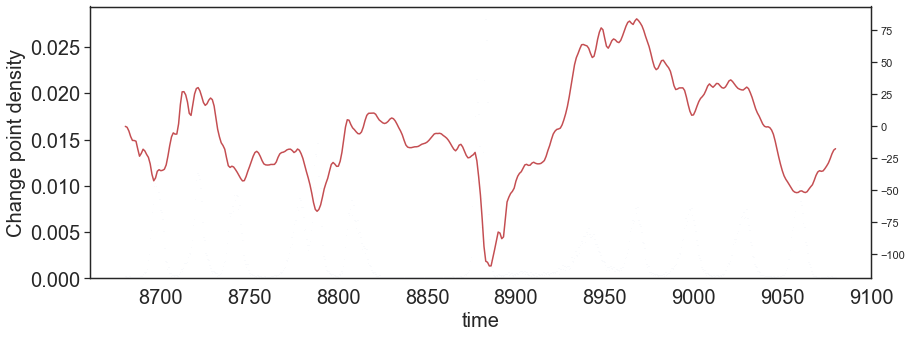

In [54]:
fig, ax = plt.subplots( figsize=(14,5))
marginal_counts, marginal_xedges, marginal_im = ax.hist( data_timing, bins=int(TIMES_MAX-TIMES_MIN)*2, range=[TIMES_MIN,TIMES_MAX],density=True)
ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('Change point density', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax1b = ax.twinx()
ax1b.plot(TIMES,Bx_dot,'r')


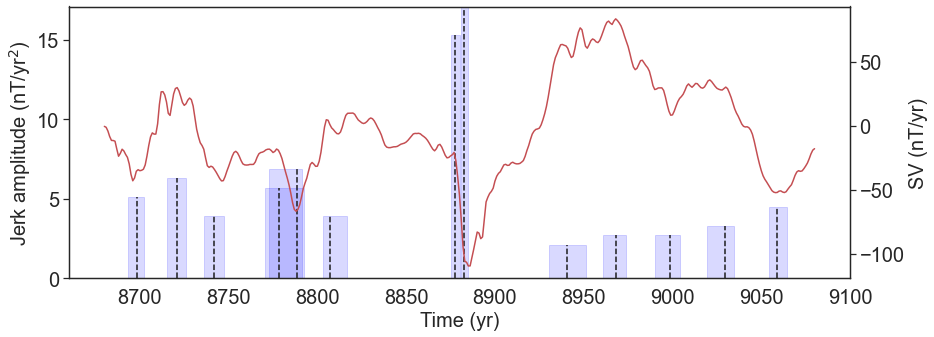

In [55]:
fig, ax = plt.subplots( figsize=(14,5))
ax.set_xlabel('Time (yr)', fontsize=20)
ax.set_ylabel('Jerk amplitude (nT/yr$^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax1b = ax.twinx()
ax1b.plot(TIMES,Bx_dot,'r')
ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
ax1b.tick_params(axis='y', which='major', labelsize=20)


ymin = 0
ymax = max(jerk[1] for jerk in jerks_info)
ax.set_ylim([ymin,ymax])
for jerk in jerks_info:
    ax.vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
    ax.fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
#plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')


11 jerks found
Jerk 0 at time 8684.750000 with min/max of 8682.000000, 8688.500000
Jerk 1 at time 8699.750000 with min/max of 8692.500000, 8705.000000
Jerk 2 at time 8709.250000 with min/max of 8691.500000, 8722.000000
Jerk 3 at time 8715.250000 with min/max of 8711.500000, 8719.500000
Jerk 4 at time 8740.750000 with min/max of 8734.500000, 8760.500000
Jerk 5 at time 8881.750000 with min/max of 8879.500000, 8883.500000
Jerk 6 at time 8893.250000 with min/max of 8891.000000, 8896.000000
Jerk 7 at time 8908.250000 with min/max of 8901.500000, 8926.000000
Jerk 8 at time 8917.750000 with min/max of 8903.000000, 8926.000000
Jerk 9 at time 8980.250000 with min/max of 8971.500000, 8986.500000
Jerk 10 at time 9029.250000 with min/max of 9019.500000, 9044.000000


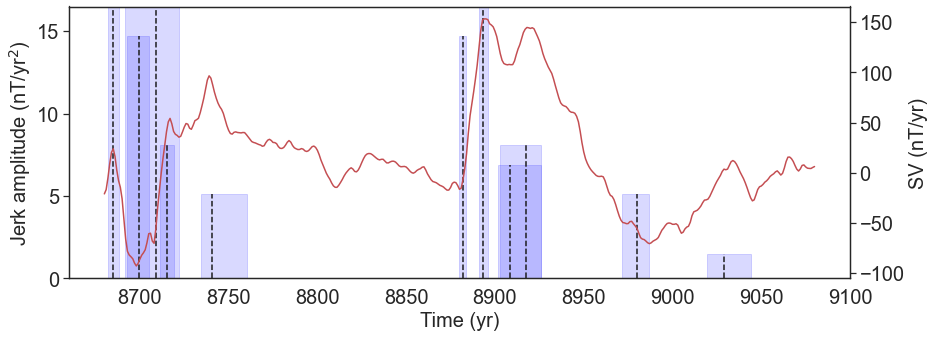

In [56]:
data_timing = jerk_data_save[0:size_jerk_data_save[1],0,1]
data_amplitude = jerk_data_save[0:size_jerk_data_save[1],1,1]
number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
number_amplitude_bins = 100
time_range = [TIMES_MIN,TIMES_MAX]
amplitude_range = [-30,30]
jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, number_amplitude_bins, \
                   time_range, amplitude_range)
    
print('{0:d} jerks found'.format(len(jerks_info)) )
for index,jerk in enumerate(jerks_info):
      print('Jerk {0:d} at time {1:f} with min/max of {2:f}, {3:f}'.format(index,jerk[0], jerk[2], jerk[3]))
        

fig, ax = plt.subplots( figsize=(14,5))
ax.set_xlabel('Time (yr)', fontsize=20)
ax.set_ylabel('Jerk amplitude (nT/yr$^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax1b = ax.twinx()
ax1b.plot(TIMES,By_dot,'r')
ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
ax1b.tick_params(axis='y', which='major', labelsize=20)


ymin = 0
ymax = max(abs(jerk[1]) for jerk in jerks_info)
ax.set_ylim([ymin,ymax])
for jerk in jerks_info:
    ax.vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
    ax.fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
#plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')


8 jerks found
Jerk 0 at time 8758.250000 with min/max of 8736.000000, 8773.500000
Jerk 1 at time 8818.750000 with min/max of 8802.500000, 8864.000000
Jerk 2 at time 8852.250000 with min/max of 8836.500000, 8863.500000
Jerk 3 at time 8878.250000 with min/max of 8874.500000, 8880.500000
Jerk 4 at time 8884.750000 with min/max of 8882.500000, 8887.500000
Jerk 5 at time 8903.750000 with min/max of 8894.000000, 8912.500000
Jerk 6 at time 8942.750000 with min/max of 8937.000000, 8949.000000
Jerk 7 at time 9065.250000 with min/max of 9057.500000, 9074.000000


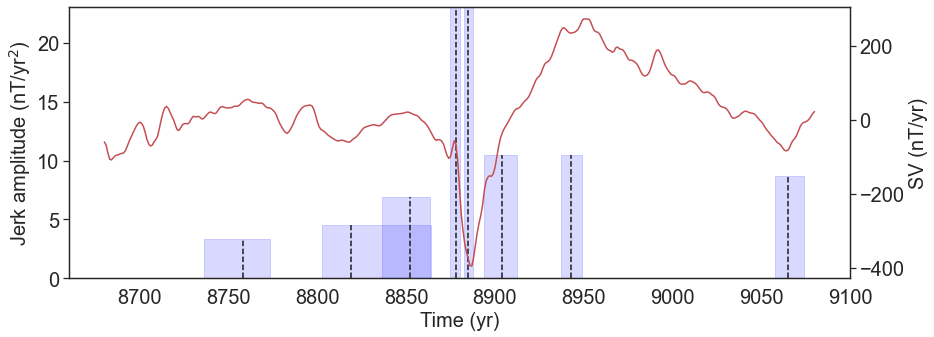

In [57]:
data_timing = jerk_data_save[0:size_jerk_data_save[2],0,2]
data_amplitude = jerk_data_save[0:size_jerk_data_save[2],1,2]
number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
number_amplitude_bins = 100
time_range = [TIMES_MIN,TIMES_MAX]
amplitude_range = [-30,30]
jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, number_amplitude_bins, \
                   time_range, amplitude_range)
    
print('{0:d} jerks found'.format(len(jerks_info)) )
for index,jerk in enumerate(jerks_info):
      print('Jerk {0:d} at time {1:f} with min/max of {2:f}, {3:f}'.format(index,jerk[0], jerk[2], jerk[3]))
        

fig, ax = plt.subplots( figsize=(14,5))
ax.set_xlabel('Time (yr)', fontsize=20)
ax.set_ylabel('Jerk amplitude (nT/yr$^2$)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax1b = ax.twinx()
ax1b.plot(TIMES,Bz_dot,'r')
ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
ax1b.tick_params(axis='y', which='major', labelsize=20)


ymin = 0
ymax = max(jerk[1] for jerk in jerks_info)
ax.set_ylim([ymin,ymax])
for jerk in jerks_info:
    ax.vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
    ax.fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
#plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')


<Figure size 432x288 with 0 Axes>

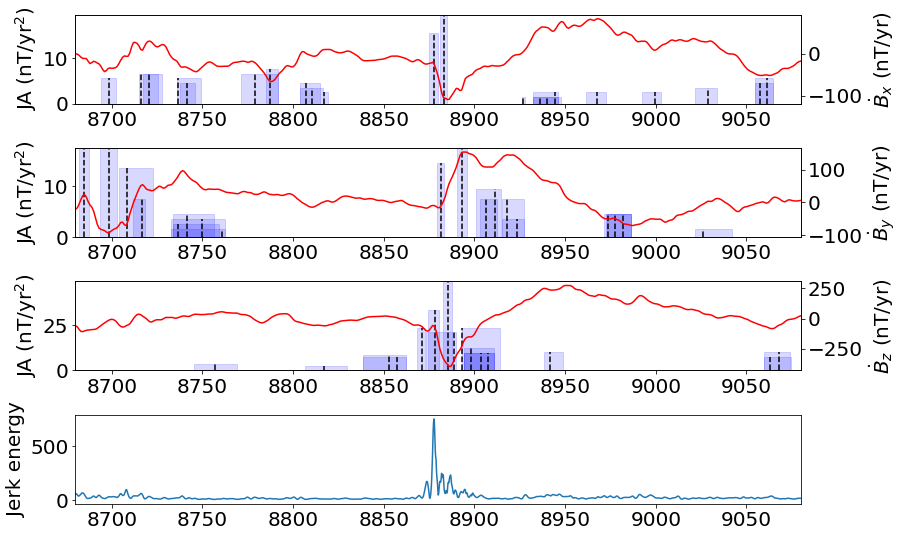

In [41]:
plt.figure()
ax=[0,1,2,3]
f, (ax[0], ax[1],ax[2],ax[3]) = plt.subplots(4, 1, figsize=(13,9) )

for cmpt in [0,1,2]:
    data_timing = jerk_data_save[0:size_jerk_data_save[cmpt],0,cmpt]
    data_amplitude = jerk_data_save[0:size_jerk_data_save[cmpt],1,cmpt]
    number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
    number_amplitude_bins = 100
    time_range = [TIMES_MIN,TIMES_MAX]
    amplitude_range = [-50,50]
    jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, number_amplitude_bins, \
                       time_range, amplitude_range)
    

    #ax[cmpt].set_xlabel('Time (yr)', fontsize=20)
    ax[cmpt].set_ylabel('JA (nT/yr$^2$)', fontsize=20)
    ax[cmpt].tick_params(axis='both', which='major', labelsize=20)
    axb = ax[cmpt].twinx()
    if cmpt == 0:
        axb.plot(TIMES,Bx_dot,'r')
        axb.set_ylabel('$\dot{B}_x$ (nT/yr)',fontsize=20)
    elif cmpt == 1:
        axb.plot(TIMES,By_dot,'r')
        axb.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
    else:
        axb.plot(TIMES,Bz_dot,'r')
        axb.set_ylabel('$\dot{B}_z$ (nT/yr)',fontsize=20)

    #ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
    axb.tick_params(axis='y', which='major', labelsize=20)

    ax[cmpt].set_xlim(TIMES_MIN, TIMES_MAX)
    ymin = 0
    ymax = max(jerk[1] for jerk in jerks_info)
    ax[cmpt].set_ylim([ymin,ymax])
    for jerk in jerks_info:
        ax[cmpt].vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
        ax[cmpt].fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
    #plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')


time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax[3].plot(time_EJ, EJ )
ax[3].set_xlim(time_yearly.min(), time_yearly.max() )
#ax[3].set_title('Jerk energy')
ax[3].set_ylabel('Jerk energy',fontsize=20)
ax[3].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


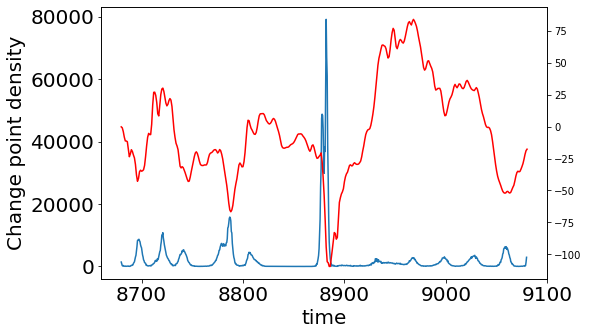

In [211]:
# Create histogram weighted by median of each bin.
# Not easy to define a jerk threshold.

fig, ax = plt.subplots( figsize=(8,5))
data_timing = jerk_data_save[0:size_jerk_data_save[0],0,0]
data_amplitude = jerk_data_save[0:size_jerk_data_save[0],1,0]

marginal_counts, marginal_xedges =  np.histogram( data_timing, bins=int(TIMES_MAX-TIMES_MIN)*2, range=[TIMES_MIN,TIMES_MAX])
bins = marginal_xedges[:]
digitized = np.digitize(data_timing, bins)
bin_medians = np.array([np.median(abs(data_amplitude[digitized == i])) for i in range(1, len(bins))])

ax.set_xlabel('time', fontsize=20)
ax.set_ylabel('Change point density', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.plot( marginal_xedges[:-1], marginal_counts * bin_medians)

ax1b = ax.twinx()
ax1b.plot(TIMES,Bx_dot,'r')

#### Try a different location

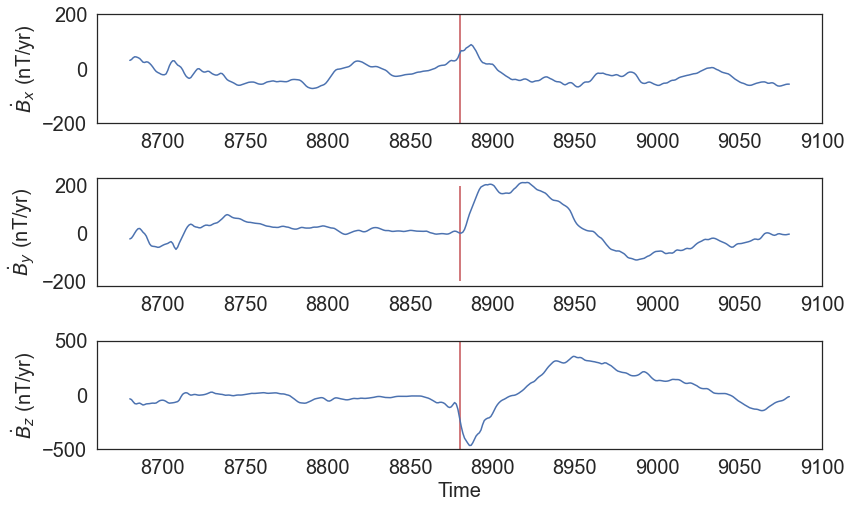

In [58]:
theta = 75
phi = 45

# plot SV series at theta = 90, phi = 45 which is close to the centre point of the jerk event in the SA.
radius = 6371.
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


a = 200
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13,8) )
ax1.vlines(jerk_times[jerk_number],-a,a,'r')
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('$\dot{B}_x$ (nT/yr)',fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)

a=200
ax2.vlines(jerk_times[jerk_number],-a,a,'r')
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
#ax2.set_ylim(-200,200)
ax2.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)

#ax2.set_title(r'$d{B_Y}/dt$')
a=500
ax3.vlines(jerk_times[jerk_number],-a,a,'r')
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-a,a)
ax3.set_xlabel('Time',fontsize=20)
ax3.set_ylabel('$\dot{B}_z$ (nT/yr)',fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)

#ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_SV_timeseries.pdf')

In [59]:
run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()

K_MIN = 0
K_MAX = 100
THIN = 100
NBINS = 100
credible = 0
RUNNING_MODE = 1
burn_in = 10000
NSAMPLE = 2000000+burn_in    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
jerk_data_save =np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2,3),dtype=float )
size_jerk_data_save  = np.zeros(3, dtype=int)

CP_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=float )

jerk_data = np.zeros( ((K_MAX - K_MIN+1)*(NSAMPLE-burn_in)//THIN,2),dtype=float )
size_jerk_data = 0

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    
    sigmas = np.array([10,5,10],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
    median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
    MARGINAL_DENSITY, N_CP_hist, jerk_data, size_jerk_data) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    jerk_data_save[:,:,i] = jerk_data
    size_jerk_data_save[i] = size_jerk_data
    
    print(i, Acceptance_rates)
    

0 [46.99100113 38.80169296  4.0139451   4.02479553]
1 [58.5951004  40.96406174  4.42636108  4.43865776]
2 [78.08679962 50.95556641  6.51719427  6.53529978]


<Figure size 432x288 with 0 Axes>

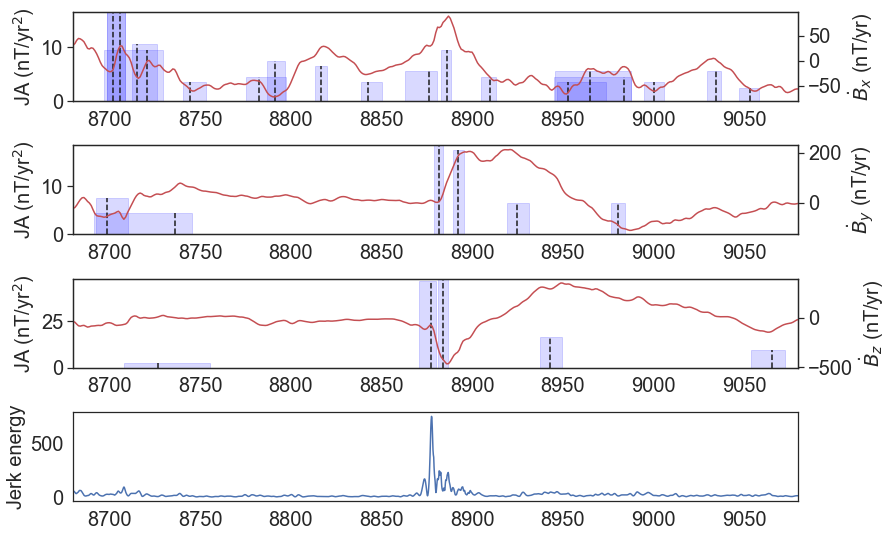

In [60]:
plt.figure()
ax=[0,1,2,3]
f, (ax[0], ax[1],ax[2],ax[3]) = plt.subplots(4, 1, figsize=(13,9) )

for cmpt in [0,1,2]:
    data_timing = jerk_data_save[0:size_jerk_data_save[cmpt],0,cmpt]
    data_amplitude = jerk_data_save[0:size_jerk_data_save[cmpt],1,cmpt]
    number_time_bins = int(TIMES_MAX-TIMES_MIN)*2
    number_amplitude_bins = 100
    time_range = [TIMES_MIN,TIMES_MAX]
    amplitude_range = [-50,50]
    jerks_info = find_jerks(data_timing, data_amplitude, number_time_bins, number_amplitude_bins, \
                       time_range, amplitude_range)
    

    #ax[cmpt].set_xlabel('Time (yr)', fontsize=20)
    ax[cmpt].set_ylabel('JA (nT/yr$^2$)', fontsize=20)
    ax[cmpt].tick_params(axis='both', which='major', labelsize=20)
    axb = ax[cmpt].twinx()
    if cmpt == 0:
        axb.plot(TIMES,Bx_dot,'r')
        axb.set_ylabel('$\dot{B}_x$ (nT/yr)',fontsize=20)
    elif cmpt == 1:
        axb.plot(TIMES,By_dot,'r')
        axb.set_ylabel('$\dot{B}_y$ (nT/yr)',fontsize=20)
    else:
        axb.plot(TIMES,Bz_dot,'r')
        axb.set_ylabel('$\dot{B}_z$ (nT/yr)',fontsize=20)

    #ax1b.set_ylabel('SV (nT/yr)',fontsize=20)
    axb.tick_params(axis='y', which='major', labelsize=20)

    ax[cmpt].set_xlim(TIMES_MIN, TIMES_MAX)
    ymin = 0
    ymax = max(jerk[1] for jerk in jerks_info)
    ax[cmpt].set_ylim([ymin,ymax])
    for jerk in jerks_info:
        ax[cmpt].vlines(jerk[0], ymin, abs(jerk[1]), colors='k',linestyles='dashed')
        ax[cmpt].fill_betweenx([ymin, abs(jerk[1])], jerk[2], jerk[3],alpha=0.15, color='blue')
    #plt.savefig('example2_posterior_with_jerks.pdf',bbox_inches='tight')


time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax[3].plot(time_EJ, EJ )
ax[3].set_xlim(time_yearly.min(), time_yearly.max() )
#ax[3].set_title('Jerk energy')
ax[3].set_ylabel('Jerk energy',fontsize=20)
ax[3].tick_params(axis='both', which='major', labelsize=20)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')
